In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**GPU**

In [ ]:
!nvidia-smi

# **Install**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from torchmetrics import Accuracy
from tqdm import tqdm
from prettytable import PrettyTable

# **Dataset 🗂️**

##Read Dataset

In [ ]:
# !cp yourdatasetaddress /content
!unrar x /content/data.rar

In [ ]:
X = pd.read_csv('/content/data/X.csv', header=None)
y = pd.read_csv('/content/data/y.csv', header=None)

##DataSplit

In [ ]:
num_samples = 327
train_ratio = 0.8
random_seed = 42

torch.manual_seed(random_seed)
train_size = int(num_samples * train_ratio)
x_train, y_train = X[:train_size], y[:train_size]
x_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
x_test, y_test = X[train_size+33:], y[train_size+33:]

##PreProcess

In [ ]:
# Convert to tensor
x_train = (torch.FloatTensor(x_train.values)).unsqueeze(dim=2)
y_train = torch.LongTensor(y_train.values)

x_val = (torch.FloatTensor(x_val.values)).unsqueeze(dim=2)
y_val = torch.LongTensor(y_val.values)

x_test = (torch.FloatTensor(x_test.values)).unsqueeze(dim=2)
y_test = torch.LongTensor(y_test.values)

In [ ]:
def MinMaxScale(data, min, max):
    return (data - min) / (max - min)

x_min = torch.min(x_train, dim=0).values
x_max = torch.max(x_train, dim=0).values

y_min = torch.min(y_train, dim=0).values
y_max = torch.max(y_train, dim=0).values

x_train = MinMaxScale(x_train, x_min, x_max)
x_val = MinMaxScale(x_val, x_min, x_max)
x_test = MinMaxScale(x_test, x_min, x_max)

y_train = MinMaxScale(y_train, y_min, y_max)
y_val = MinMaxScale(y_val, y_min, y_max)
y_test = MinMaxScale(y_test, y_min, y_max)

In [ ]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


## DataLoader

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

torch.Size([10, 5, 1]) torch.Size([10, 1])


# **Model 🧠**

##Custom Model

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, batch_first, bidirectional, out_feature):
    super().__init__()
    self.rnn = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
    self.fc = nn.LazyLinear(out_feature)

  def forward(self, x):
    outputs, hn = self.rnn(x)
    outputs = outputs.flatten(1)
    y = self.fc(outputs) # many to many

    return y

##RNN

In [ ]:
rnn = RNNModel(nn.RNN, 1, 4, 1, True, False, 1)
print(rnn)
print(rnn(x_batch).shape)

RNNModel(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


##LSTM

In [ ]:
lstm = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1)
print(lstm)
print(lstm(x_batch).shape)

RNNModel(
  (rnn): LSTM(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


##GRU

In [ ]:
gru = RNNModel(nn.GRU, 1, 4, 1, True, False, 1)
print(gru)
print(gru(x_batch).shape)

RNNModel(
  (rnn): GRU(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


##CNNLSTM

In [ ]:
class CNNLSTM(nn.Module):

  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, out_feature):
    super().__init__()

    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=2, stride=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)

    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers)

    self.fc = nn.LazyLinear(out_feature)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()

    y = y.permute(0, 2, 1)
    y, _ = self.lstm(x)
    y = self.fc(y)
    return y.mean(dim=1)

In [ ]:
model = CNNLSTM(1, 5, 4, 1, 1)
model(x_batch).shape

torch.Size([10, 1])

##GRU From Scratch

In [ ]:
class Gate(nn.Module):
  def __init__(self, hidden_size, af):
    super().__init__()
    self.fcx = nn.LazyLinear(hidden_size)
    self.fch = nn.LazyLinear(hidden_size)
    self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

  def forward(self, x, h):
    return self.af(self.fcx(x)+self.fch(h))

mygate = Gate(4, 'tanh')
mygate

mygate(torch.randn(3, 4), torch.randn(3, 8)).shape

torch.Size([3, 4])

In [ ]:
class GRU(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.reset_gate = Gate(hidden_size, 'sigmoid')
    self.update_gate = Gate(hidden_size, 'sigmoid')
    self.candidate_hidden_state = Gate(hidden_size, 'tanh')

  def forward(self, x):
    ht = torch.zeros(self.hidden_size)
    output = []

    for xt in x:
      rt = self.reset_gate(xt, ht)
      rht = rt * ht
      #
      h_tilda = self.candidate_hidden_state(xt, rht)
      #
      zt = self.update_gate(xt, ht)
      ht = zt * ht + (1-zt) * h_tilda
      output.append(ht)
    return output, ht

In [ ]:
gru = GRU(4)
gru

GRU(
  (reset_gate): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Sigmoid()
  )
  (update_gate): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Sigmoid()
  )
  (candidate_hidden_state): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Tanh()
  )
)

###Test GRU

In [ ]:
output, ht = gru(torch.randn(8, 10))
print(len(output))
print(output[0].shape)

8
torch.Size([4])


# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)

# **Loss & Optimizer ⚖️**

In [ ]:
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss_valid.update(loss.item())
  return loss_valid.avg

# **Efficient way for set hyperparams 🔨**

You should do this part for all models(RNN,LSTM,GRU,CNNLSTM) and save their results.

## Step 1: check forward path

Calculate loss for one batch

##RNN Model

In [ ]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.0317, grad_fn=<MeanBackward0>)


##LSTM Model

In [ ]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.0132, grad_fn=<MeanBackward0>)


##GRU Model

In [ ]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.0644, grad_fn=<MeanBackward0>)


##CNNLSTM Model

In [ ]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.2103, grad_fn=<MeanBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_dataset, (len(train_dataset)-64, 64))
mini_train_loader = DataLoader(mini_train_dataset, 8)

# RNN, LSTM, GRU

In [ ]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 65.31batch/s, loss=0.0722]


In [ ]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model, _= train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 68.35batch/s, loss=0.085]


In [ ]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 59.71batch/s, loss=0.078]


# CNNLSTM

In [ ]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 83.60batch/s, loss=0.0406]


## Step 3: select best lr

Train all data for 3 epochs

# RNN, LSTM, GRU

In [ ]:
# RNN, LSTM, GRU
num_epochs = 3

for mdl in [nn.RNN, nn.LSTM, nn.GRU]:
  print(f'model={mdl}')
  for lr in [0.01, 0.001, 0.0015, 0.0001]:
    print(f'LR={lr}')
    model = RNNModel(mdl, 1, 4, 1, True, False, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
      model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()


model=<class 'torch.nn.modules.rnn.RNN'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 101.00batch/s, loss=0.0825]



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 108.14batch/s, loss=0.0781]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 46.05batch/s, loss=0.109]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 74.32batch/s, loss=0.0964]



model=<class 'torch.nn.modules.rnn.LSTM'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 96.97batch/s, loss=0.0868]



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 98.27batch/s, loss=0.0928]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 35.65batch/s, loss=0.0811]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 56.87batch/s, loss=0.0711]



model=<class 'torch.nn.modules.rnn.GRU'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 40.54batch/s, loss=0.085]



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 74.62batch/s, loss=0.075]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 74.50batch/s, loss=0.0915]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 56.27batch/s, loss=0.0997]

# CNNLSTM

In [ ]:
# CNNLSTM
num_epochs = 3

print()
for lr in [0.01, 0.001, 0.0015, 0.0001]:
    print(f'Model: CNNLSTM, LR={lr}')
    model = CNNLSTM(1, 5, 4, 1, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
      model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()


Model: CNNLSTM, LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 101.07batch/s, loss=0.115]



Model: CNNLSTM, LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 93.14batch/s, loss=0.0843]



Model: CNNLSTM, LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 82.18batch/s, loss=0.0744]



Model: CNNLSTM, LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 87.67batch/s, loss=0.247]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



# RNN, LSTM, GRU

In [ ]:
num_epochs = 5

my_table = PrettyTable([ "Model", "Learning Rate", "Weight decay", "loss"])


for RNN in [nn.RNN, nn.LSTM, nn.GRU]:
  print(f'model={RNN}')
  for lr in [0.01, 0.001, 0.0015, 0.0001]:
    for wd in [0., 1e-4, 1e-5]:

      model = RNNModel(RNN, 1, 4, 1, True, False, 1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

      print(f'LR={lr}, WD={wd}')
      for epoch in range(5):
        model, loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

        if epoch == 4:
          my_table.add_row([RNN, lr, wd, f'{loss:.4f}'])

      print()

  my_table.add_row([20*'-', 20*'-', 20*'-', 20*'-'])

print(my_table)



model=<class 'torch.nn.modules.rnn.RNN'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 53.29batch/s, loss=0.0694]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 117.15batch/s, loss=0.0842]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 40.17batch/s, loss=0.041]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 89.32batch/s, loss=0.1]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 89.78batch/s, loss=0.0918]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 94.20batch/s, loss=0.0471]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 93.18batch/s, loss=0.0908]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 87.76batch/s, loss=0.0883]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 77.59batch/s, loss=0.0804]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 100.27batch/s, loss=0.0761]



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 102.79batch/s, loss=0.186]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 111.83batch/s, loss=0.466]



model=<class 'torch.nn.modules.rnn.LSTM'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.22batch/s, loss=0.0743]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 71.34batch/s, loss=0.0783]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 100.62batch/s, loss=0.0648]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 95.20batch/s, loss=0.0737]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 66.75batch/s, loss=0.077]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 66.34batch/s, loss=0.0792]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 97.11batch/s, loss=0.0835]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 106.83batch/s, loss=0.0846]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 92.49batch/s, loss=0.0888]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 88.02batch/s, loss=0.135]



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 113.33batch/s, loss=0.212]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 109.12batch/s, loss=0.136]



model=<class 'torch.nn.modules.rnn.GRU'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 42.38batch/s, loss=0.0711]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 85.39batch/s, loss=0.0407]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 99.63batch/s, loss=0.0378] 



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 83.54batch/s, loss=0.0917]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 60.75batch/s, loss=0.0774]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 78.87batch/s, loss=0.0783]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 70.41batch/s, loss=0.0874]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 96.18batch/s, loss=0.0719]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 77.88batch/s, loss=0.0733]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 85.31batch/s, loss=0.12]



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 94.87batch/s, loss=0.202]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 80.58batch/s, loss=0.0959]



+-------------------------------------+----------------------+----------------------+----------------------+
|                Model                |    Learning Rate     |     Weight decay     |         loss         |
+-------------------------------------+----------------------+----------------------+----------------------+
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |         0.0          |        0.0694        |
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |        0.0001        |        0.0842        |
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |        1e-05         |        0.0410        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |         0.0          |        0.1003        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |        0.0001        |        0.0918        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |        1e-05         |        0.0471        |
|  <class 'torch.n

# CNNLSTM

In [ ]:
num_epochs = 5

my_table = PrettyTable(["Learning Rate", "Weight decay", "loss"])

for lr in [0.001, 0.0015, 0.0001]:
    for wd in [0., 1e-4, 1e-5]:

      model = CNNLSTM(1, 5, 4, 1, 1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

      print(f'LR={lr}, WD={wd}')
      for epoch in range(5):
        model, loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

        if epoch == 4:
          my_table.add_row([lr, wd, f'{loss:.4f}'])

      print()

print(my_table)

LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 105.25batch/s, loss=0.093]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 110.40batch/s, loss=0.0998]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 115.10batch/s, loss=0.0661]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 83.56batch/s, loss=0.0772]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 112.60batch/s, loss=0.0991]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 71.28batch/s, loss=0.0622]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 97.63batch/s, loss=0.0822] 



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 96.92batch/s, loss=0.121]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.17batch/s, loss=0.136]



+---------------+--------------+--------+
| Learning Rate | Weight decay |  loss  |
+---------------+--------------+--------+
|     0.001     |     0.0      | 0.0930 |
|     0.001     |    0.0001    | 0.0998 |
|     0.001     |    1e-05     | 0.0661 |
|     0.0015    |     0.0      | 0.0772 |
|     0.0015    |    0.0001    | 0.0991 |
|     0.0015    |    1e-05     | 0.0622 |
|     0.0001    |     0.0      | 0.0822 |
|     0.0001    |    0.0001    | 0.1210 |
|     0.0001    |    1e-05     | 0.1358 |
+---------------+--------------+--------+


Model    | RNN      | LSTM    | GRU       | ‫‪CNNLSTM‬‬
---------|----------|---------|-----------|-------------  
best lr  | 0.01   |  0.01   |  0.01   | 0.0015
---------|----------|---------|-----------|-------------  
wd       | 1e-05    |  1e-5   |  1e-05    | 1e-05

## Step 5: train more epochs

# train CNNLSTM

In [ ]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)

In [ ]:
lr = 0.0015    # cnnlstm
wd = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, '/content/cnnlstm-model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'/content/cnnlstm-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/cnnlstm-loss-valid.pt')

Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 72.01batch/s, loss=0.299]


Valid: Loss = 0.8213
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 86.10batch/s, loss=0.137]


Valid: Loss = 0.6982
Model Saved!



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 89.03batch/s, loss=0.0931]


Valid: Loss = 0.6647
Model Saved!



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 102.64batch/s, loss=0.0847]


Valid: Loss = 0.6511
Model Saved!



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 112.42batch/s, loss=0.0752]


Valid: Loss = 0.6113
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 94.79batch/s, loss=0.0707]


Valid: Loss = 0.5814
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 107.24batch/s, loss=0.0633]


Valid: Loss = 0.5413
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 108.45batch/s, loss=0.0593]


Valid: Loss = 0.5107
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 102.59batch/s, loss=0.0551]


Valid: Loss = 0.4801
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 98.47batch/s, loss=0.0539]


Valid: Loss = 0.4578
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 87.88batch/s, loss=0.0512]


Valid: Loss = 0.4393
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 86.51batch/s, loss=0.0498]


Valid: Loss = 0.4258
Model Saved!



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 75.11batch/s, loss=0.0496]


Valid: Loss = 0.4176
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 86.15batch/s, loss=0.0477]


Valid: Loss = 0.4056
Model Saved!



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 95.54batch/s, loss=0.0476]


Valid: Loss = 0.4018
Model Saved!



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 100.51batch/s, loss=0.0471]


Valid: Loss = 0.4066



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 92.80batch/s, loss=0.0465]


Valid: Loss = 0.3957
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 81.28batch/s, loss=0.0456]


Valid: Loss = 0.3975



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 72.08batch/s, loss=0.0453]


Valid: Loss = 0.4014



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 52.74batch/s, loss=0.0448]


Valid: Loss = 0.3921
Model Saved!



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 79.42batch/s, loss=0.0444]


Valid: Loss = 0.3923



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 85.41batch/s, loss=0.0444]


Valid: Loss = 0.3936



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 75.93batch/s, loss=0.0439]


Valid: Loss = 0.3932



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 95.21batch/s, loss=0.0436]


Valid: Loss = 0.3933



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 89.81batch/s, loss=0.0432]


Valid: Loss = 0.3862
Model Saved!



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 67.55batch/s, loss=0.0428]


Valid: Loss = 0.3848
Model Saved!



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 64.13batch/s, loss=0.0426]


Valid: Loss = 0.3842
Model Saved!



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 81.16batch/s, loss=0.0418]


Valid: Loss = 0.3827
Model Saved!



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 91.65batch/s, loss=0.0416]


Valid: Loss = 0.3804
Model Saved!



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 93.98batch/s, loss=0.0415]


Valid: Loss = 0.3775
Model Saved!



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 97.18batch/s, loss=0.0412]


Valid: Loss = 0.3742
Model Saved!



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 87.11batch/s, loss=0.0406]


Valid: Loss = 0.3712
Model Saved!



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 40.48batch/s, loss=0.0409]


Valid: Loss = 0.3705
Model Saved!



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 51.59batch/s, loss=0.0403]


Valid: Loss = 0.3669
Model Saved!



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 54.17batch/s, loss=0.0401]


Valid: Loss = 0.3644
Model Saved!



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 56.43batch/s, loss=0.0396]


Valid: Loss = 0.3608
Model Saved!



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 36.60batch/s, loss=0.0396]


Valid: Loss = 0.3576
Model Saved!



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 52.17batch/s, loss=0.0392]


Valid: Loss = 0.353
Model Saved!



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 62.68batch/s, loss=0.0392]


Valid: Loss = 0.348
Model Saved!



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 63.61batch/s, loss=0.0387]


Valid: Loss = 0.3402
Model Saved!



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 92.10batch/s, loss=0.0387]


Valid: Loss = 0.3344
Model Saved!



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 74.98batch/s, loss=0.0379]


Valid: Loss = 0.326
Model Saved!



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 71.37batch/s, loss=0.0381]


Valid: Loss = 0.3266



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 46.30batch/s, loss=0.0378]


Valid: Loss = 0.319
Model Saved!



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 53.67batch/s, loss=0.0373]


Valid: Loss = 0.3172
Model Saved!



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 59.92batch/s, loss=0.0375]


Valid: Loss = 0.3174



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 57.23batch/s, loss=0.0366]


Valid: Loss = 0.3076
Model Saved!



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 72.03batch/s, loss=0.0369]


Valid: Loss = 0.3058
Model Saved!



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 62.70batch/s, loss=0.0364]


Valid: Loss = 0.2973
Model Saved!



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 49.79batch/s, loss=0.0356]


Valid: Loss = 0.2963
Model Saved!



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 70.10batch/s, loss=0.0361]


Valid: Loss = 0.2914
Model Saved!



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 70.60batch/s, loss=0.0353]


Valid: Loss = 0.2908
Model Saved!



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 72.04batch/s, loss=0.035]


Valid: Loss = 0.2835
Model Saved!



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 46.39batch/s, loss=0.0348]


Valid: Loss = 0.2833
Model Saved!



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 68.40batch/s, loss=0.0347]


Valid: Loss = 0.2764
Model Saved!



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 81.43batch/s, loss=0.0345]


Valid: Loss = 0.269
Model Saved!



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 92.67batch/s, loss=0.0342]


Valid: Loss = 0.2684
Model Saved!



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 113.50batch/s, loss=0.0341]


Valid: Loss = 0.2612
Model Saved!



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 104.84batch/s, loss=0.0337]


Valid: Loss = 0.2602
Model Saved!



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 104.72batch/s, loss=0.0336]


Valid: Loss = 0.2519
Model Saved!



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 85.25batch/s, loss=0.0331]


Valid: Loss = 0.2501
Model Saved!



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 98.07batch/s, loss=0.0329] 


Valid: Loss = 0.2442
Model Saved!



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 90.22batch/s, loss=0.0323]


Valid: Loss = 0.2517



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 99.99batch/s, loss=0.0328]


Valid: Loss = 0.2445



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 107.10batch/s, loss=0.0324]


Valid: Loss = 0.2442



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 99.01batch/s, loss=0.0319]


Valid: Loss = 0.2428
Model Saved!



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 88.55batch/s, loss=0.0324]


Valid: Loss = 0.2423
Model Saved!



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 115.65batch/s, loss=0.0322]


Valid: Loss = 0.245



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 101.11batch/s, loss=0.0317]


Valid: Loss = 0.242
Model Saved!



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 108.19batch/s, loss=0.0318]


Valid: Loss = 0.2406
Model Saved!



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 80.19batch/s, loss=0.0318]


Valid: Loss = 0.2418



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 89.65batch/s, loss=0.0317]


Valid: Loss = 0.2434



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 76.98batch/s, loss=0.0312]


Valid: Loss = 0.2381
Model Saved!



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 86.99batch/s, loss=0.0316]


Valid: Loss = 0.2376
Model Saved!



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 81.93batch/s, loss=0.0312]


Valid: Loss = 0.239



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 87.40batch/s, loss=0.0319]


Valid: Loss = 0.2396



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 81.70batch/s, loss=0.0311]


Valid: Loss = 0.2328
Model Saved!



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 97.14batch/s, loss=0.0314]


Valid: Loss = 0.2355



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 87.50batch/s, loss=0.0308]


Valid: Loss = 0.2376



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 95.03batch/s, loss=0.0314]


Valid: Loss = 0.2368



# train RNNModel

In [ ]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
lr = 0.0015     # rnn
wd = 1e-04

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, '/content/rnn-model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'/content/rnn-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/rnn-loss-valid.pt')


Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 79.60batch/s, loss=0.0314]


Valid: Loss = 0.2283
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 70.21batch/s, loss=0.0313]


Valid: Loss = 0.2339



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 87.52batch/s, loss=0.0307]


Valid: Loss = 0.2414



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 95.04batch/s, loss=0.0314]


Valid: Loss = 0.2297



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 94.90batch/s, loss=0.0306]


Valid: Loss = 0.2331



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 105.16batch/s, loss=0.0311]


Valid: Loss = 0.2327



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 104.89batch/s, loss=0.0305]


Valid: Loss = 0.2343



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 109.91batch/s, loss=0.0309]


Valid: Loss = 0.236



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 67.75batch/s, loss=0.0304]


Valid: Loss = 0.2303



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 93.46batch/s, loss=0.0308]


Valid: Loss = 0.2364



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 88.75batch/s, loss=0.0305]


Valid: Loss = 0.2276
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 92.04batch/s, loss=0.0305]


Valid: Loss = 0.2351



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 94.08batch/s, loss=0.0304]


Valid: Loss = 0.221
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 108.66batch/s, loss=0.0305]


Valid: Loss = 0.2319



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 108.21batch/s, loss=0.03]


Valid: Loss = 0.2352



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 101.09batch/s, loss=0.0302]


Valid: Loss = 0.2301



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 100.77batch/s, loss=0.0299]


Valid: Loss = 0.2371



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 91.50batch/s, loss=0.0306]


Valid: Loss = 0.2234



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 96.41batch/s, loss=0.0299]


Valid: Loss = 0.2334



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 88.37batch/s, loss=0.0305]


Valid: Loss = 0.2313



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 87.58batch/s, loss=0.03]


Valid: Loss = 0.2203
Model Saved!



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 88.27batch/s, loss=0.0306]


Valid: Loss = 0.2255



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 70.33batch/s, loss=0.0297]


Valid: Loss = 0.2339



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 39.82batch/s, loss=0.03]


Valid: Loss = 0.219
Model Saved!



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 78.64batch/s, loss=0.0299]


Valid: Loss = 0.2311



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 81.90batch/s, loss=0.0297]


Valid: Loss = 0.2189
Model Saved!



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 91.34batch/s, loss=0.03]


Valid: Loss = 0.2256



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 88.92batch/s, loss=0.0296]


Valid: Loss = 0.2281



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 97.59batch/s, loss=0.0299]


Valid: Loss = 0.2304



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 94.91batch/s, loss=0.0295]


Valid: Loss = 0.2277



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 57.30batch/s, loss=0.0298]


Valid: Loss = 0.2327



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 44.76batch/s, loss=0.0297]


Valid: Loss = 0.2215



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 38.35batch/s, loss=0.0296]


Valid: Loss = 0.2275



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 45.21batch/s, loss=0.0295]


Valid: Loss = 0.227



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 64.87batch/s, loss=0.0298]


Valid: Loss = 0.2261



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 65.51batch/s, loss=0.0295]


Valid: Loss = 0.2217



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 55.97batch/s, loss=0.0299]


Valid: Loss = 0.2247



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 59.28batch/s, loss=0.0293]


Valid: Loss = 0.2248



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 44.12batch/s, loss=0.0297]


Valid: Loss = 0.2255



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 52.51batch/s, loss=0.0294]


Valid: Loss = 0.2272



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 67.57batch/s, loss=0.0295]


Valid: Loss = 0.2289



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 108.18batch/s, loss=0.0293]


Valid: Loss = 0.2211



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 100.82batch/s, loss=0.0299]


Valid: Loss = 0.2262



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 97.08batch/s, loss=0.0293]


Valid: Loss = 0.222



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 92.16batch/s, loss=0.0297]


Valid: Loss = 0.2249



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 100.79batch/s, loss=0.0293]


Valid: Loss = 0.2261



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 100.31batch/s, loss=0.0292]


Valid: Loss = 0.2315



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 94.62batch/s, loss=0.0293]


Valid: Loss = 0.2187
Model Saved!



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 98.02batch/s, loss=0.0293] 


Valid: Loss = 0.2246



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 99.30batch/s, loss=0.0292]


Valid: Loss = 0.2201



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 84.73batch/s, loss=0.0292]


Valid: Loss = 0.2268



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 94.73batch/s, loss=0.0292]


Valid: Loss = 0.22



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 92.79batch/s, loss=0.0292]


Valid: Loss = 0.225



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 100.53batch/s, loss=0.0292]


Valid: Loss = 0.2189



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 93.88batch/s, loss=0.0293]


Valid: Loss = 0.2214



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 96.07batch/s, loss=0.0291]


Valid: Loss = 0.2227



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 98.86batch/s, loss=0.0293] 


Valid: Loss = 0.2236



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 96.74batch/s, loss=0.0291] 


Valid: Loss = 0.2168
Model Saved!



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 78.85batch/s, loss=0.0296]


Valid: Loss = 0.224



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 65.13batch/s, loss=0.0291]


Valid: Loss = 0.2202



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 67.32batch/s, loss=0.0289]


Valid: Loss = 0.2265



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 62.07batch/s, loss=0.0291]


Valid: Loss = 0.2183



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 54.93batch/s, loss=0.0291]


Valid: Loss = 0.2235



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 77.52batch/s, loss=0.029]


Valid: Loss = 0.2193



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 80.57batch/s, loss=0.0292]


Valid: Loss = 0.2196



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 67.30batch/s, loss=0.029]


Valid: Loss = 0.2221



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 92.48batch/s, loss=0.0291]


Valid: Loss = 0.226



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 92.73batch/s, loss=0.029]


Valid: Loss = 0.2227



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 92.70batch/s, loss=0.029]


Valid: Loss = 0.2242



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 78.85batch/s, loss=0.0291]


Valid: Loss = 0.2181



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 68.33batch/s, loss=0.0287]


Valid: Loss = 0.2261



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 63.53batch/s, loss=0.029]


Valid: Loss = 0.2201



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 49.39batch/s, loss=0.0292]


Valid: Loss = 0.2208



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 47.90batch/s, loss=0.0289]


Valid: Loss = 0.2221



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 60.47batch/s, loss=0.0288]


Valid: Loss = 0.2239



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 50.19batch/s, loss=0.029]


Valid: Loss = 0.2169



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 51.26batch/s, loss=0.029]


Valid: Loss = 0.2212



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 52.86batch/s, loss=0.0288]


Valid: Loss = 0.215
Model Saved!



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 59.33batch/s, loss=0.0286]


Valid: Loss = 0.2242



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 63.71batch/s, loss=0.0289]


Valid: Loss = 0.2154



# train LSTMModel

In [ ]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
lr = 0.01     # lstm
wd = 1e-04


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, '/content/lstm-model.pt')


    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'/content/lstm-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/lstm-loss-valid.pt')


Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 85.97batch/s, loss=0.107]


Valid: Loss = 0.7308
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 98.22batch/s, loss=0.0868]


Valid: Loss = 0.6898
Model Saved!



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 73.36batch/s, loss=0.0903]


Valid: Loss = 0.6509
Model Saved!



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 73.09batch/s, loss=0.0728]


Valid: Loss = 0.4095
Model Saved!



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 73.58batch/s, loss=0.0662]


Valid: Loss = 0.297
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 103.91batch/s, loss=0.0607]


Valid: Loss = 0.2286
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 106.26batch/s, loss=0.0609]


Valid: Loss = 0.3831



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 92.70batch/s, loss=0.0531]


Valid: Loss = 0.2024
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 99.54batch/s, loss=0.0485]


Valid: Loss = 0.2106



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 107.56batch/s, loss=0.0544]


Valid: Loss = 0.1973
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 105.60batch/s, loss=0.0534]


Valid: Loss = 0.2415



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 80.13batch/s, loss=0.0492]


Valid: Loss = 0.1986



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 69.73batch/s, loss=0.0502]


Valid: Loss = 0.2441



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 73.58batch/s, loss=0.0472]


Valid: Loss = 0.227



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 93.97batch/s, loss=0.0431]


Valid: Loss = 0.2536



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 97.18batch/s, loss=0.0437]


Valid: Loss = 0.2214



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 105.04batch/s, loss=0.0391]


Valid: Loss = 0.1711
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 97.69batch/s, loss=0.035]


Valid: Loss = 0.1852



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 98.56batch/s, loss=0.0333]


Valid: Loss = 0.2083



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 29.96batch/s, loss=0.0381]


Valid: Loss = 0.194



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 71.51batch/s, loss=0.0329]


Valid: Loss = 0.2202



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 73.04batch/s, loss=0.0369]


Valid: Loss = 0.1616
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 88.08batch/s, loss=0.034]


Valid: Loss = 0.1651



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 96.82batch/s, loss=0.0345]


Valid: Loss = 0.1915



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 91.31batch/s, loss=0.0338]


Valid: Loss = 0.1896



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 77.41batch/s, loss=0.03]


Valid: Loss = 0.2198



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 75.29batch/s, loss=0.0349]


Valid: Loss = 0.1527
Model Saved!



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 71.51batch/s, loss=0.0363]


Valid: Loss = 0.2007



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 89.64batch/s, loss=0.0325]


Valid: Loss = 0.1961



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 93.50batch/s, loss=0.0345]


Valid: Loss = 0.1494
Model Saved!



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 90.96batch/s, loss=0.0369]


Valid: Loss = 0.1977



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 90.14batch/s, loss=0.0327]


Valid: Loss = 0.2082



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 85.96batch/s, loss=0.0358]


Valid: Loss = 0.1695



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 44.98batch/s, loss=0.0332]


Valid: Loss = 0.2063



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 47.62batch/s, loss=0.0331]


Valid: Loss = 0.1754



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 54.31batch/s, loss=0.0298]


Valid: Loss = 0.218



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 60.21batch/s, loss=0.0339]


Valid: Loss = 0.1538



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 76.00batch/s, loss=0.0307]


Valid: Loss = 0.2037



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 31.24batch/s, loss=0.0347]


Valid: Loss = 0.1802



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 61.89batch/s, loss=0.0379]


Valid: Loss = 0.1927



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 69.92batch/s, loss=0.0322]


Valid: Loss = 0.1796



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 57.67batch/s, loss=0.0313]


Valid: Loss = 0.2001



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 57.25batch/s, loss=0.0349]


Valid: Loss = 0.1329
Model Saved!



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 58.50batch/s, loss=0.0326]


Valid: Loss = 0.1823



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 28.11batch/s, loss=0.0329]


Valid: Loss = 0.1906



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 35.30batch/s, loss=0.0314]


Valid: Loss = 0.1795



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 54.56batch/s, loss=0.0344]


Valid: Loss = 0.1538



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 64.56batch/s, loss=0.0322]


Valid: Loss = 0.1577



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 49.40batch/s, loss=0.0312]


Valid: Loss = 0.1715



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 60.77batch/s, loss=0.0302]


Valid: Loss = 0.2095



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 45.89batch/s, loss=0.0328]


Valid: Loss = 0.1826



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 72.85batch/s, loss=0.0357]


Valid: Loss = 0.1726



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 87.54batch/s, loss=0.0314]


Valid: Loss = 0.173



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 99.34batch/s, loss=0.0305]


Valid: Loss = 0.1729



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 110.83batch/s, loss=0.0313]


Valid: Loss = 0.1859



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 96.91batch/s, loss=0.0339]


Valid: Loss = 0.1505



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 98.45batch/s, loss=0.0301]


Valid: Loss = 0.1789



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 105.66batch/s, loss=0.0341]


Valid: Loss = 0.1545



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 116.11batch/s, loss=0.0349]


Valid: Loss = 0.1894



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 106.31batch/s, loss=0.0323]


Valid: Loss = 0.1688



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 100.61batch/s, loss=0.0313]


Valid: Loss = 0.1547



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 94.56batch/s, loss=0.0311]


Valid: Loss = 0.1963



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 101.90batch/s, loss=0.0338]


Valid: Loss = 0.174



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 99.35batch/s, loss=0.0323]


Valid: Loss = 0.2038



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 87.55batch/s, loss=0.0329]


Valid: Loss = 0.1726



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 97.43batch/s, loss=0.0295]


Valid: Loss = 0.1825



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 93.51batch/s, loss=0.0336]


Valid: Loss = 0.1542



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 83.60batch/s, loss=0.0352]


Valid: Loss = 0.1926



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 92.30batch/s, loss=0.0324]


Valid: Loss = 0.1876



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 91.71batch/s, loss=0.0308]


Valid: Loss = 0.2082



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 102.03batch/s, loss=0.0344]


Valid: Loss = 0.1497



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 98.26batch/s, loss=0.0314] 


Valid: Loss = 0.1781



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 103.38batch/s, loss=0.0332]


Valid: Loss = 0.1401



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 100.84batch/s, loss=0.0348]


Valid: Loss = 0.1891



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 113.23batch/s, loss=0.0319]


Valid: Loss = 0.1711



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 108.94batch/s, loss=0.0305]


Valid: Loss = 0.186



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 105.38batch/s, loss=0.031]


Valid: Loss = 0.1641



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 91.06batch/s, loss=0.0307]


Valid: Loss = 0.1732



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 91.46batch/s, loss=0.0348]


Valid: Loss = 0.137



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 86.43batch/s, loss=0.0309]


Valid: Loss = 0.1947



# train GRUModel

In [ ]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)

In [ ]:
lr = 0.0015    # gru
wd = 1e-05

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [ ]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, '/content/gru-model.pt')

    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1


torch.save(torch.tensor(loss_train_hist), f'/content/gru-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'/content/gru-loss-valid.pt')


Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 90.89batch/s, loss=0.0831]


Valid: Loss = 0.6197
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 101.54batch/s, loss=0.0796]


Valid: Loss = 0.619
Model Saved!



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 99.15batch/s, loss=0.0727] 


Valid: Loss = 0.6002
Model Saved!



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 100.34batch/s, loss=0.0738]


Valid: Loss = 0.5895
Model Saved!



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 101.47batch/s, loss=0.0712]


Valid: Loss = 0.5758
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 93.36batch/s, loss=0.0693]


Valid: Loss = 0.5592
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 96.81batch/s, loss=0.0665]


Valid: Loss = 0.5395
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 87.84batch/s, loss=0.0658]


Valid: Loss = 0.5238
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 78.01batch/s, loss=0.0617]


Valid: Loss = 0.4974
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 79.54batch/s, loss=0.0623]


Valid: Loss = 0.4821
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 87.53batch/s, loss=0.0564]


Valid: Loss = 0.4463
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 87.08batch/s, loss=0.0569]


Valid: Loss = 0.428
Model Saved!



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 87.65batch/s, loss=0.053]


Valid: Loss = 0.3972
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 90.19batch/s, loss=0.0519]


Valid: Loss = 0.3712
Model Saved!



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 90.92batch/s, loss=0.0469]


Valid: Loss = 0.3328
Model Saved!



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 66.52batch/s, loss=0.0462]


Valid: Loss = 0.3071
Model Saved!



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 73.80batch/s, loss=0.045]


Valid: Loss = 0.2897
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 79.37batch/s, loss=0.044]


Valid: Loss = 0.2757
Model Saved!



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 93.35batch/s, loss=0.0433]


Valid: Loss = 0.264
Model Saved!



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 96.47batch/s, loss=0.0437]


Valid: Loss = 0.2585
Model Saved!



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 88.12batch/s, loss=0.0424]


Valid: Loss = 0.2483
Model Saved!



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 80.94batch/s, loss=0.0424]


Valid: Loss = 0.242
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 66.52batch/s, loss=0.0422]


Valid: Loss = 0.2355
Model Saved!



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 65.13batch/s, loss=0.0421]


Valid: Loss = 0.2303
Model Saved!



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 69.60batch/s, loss=0.0411]


Valid: Loss = 0.2213
Model Saved!



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 75.93batch/s, loss=0.0416]


Valid: Loss = 0.2224



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 74.78batch/s, loss=0.0406]


Valid: Loss = 0.22
Model Saved!



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 72.45batch/s, loss=0.041]


Valid: Loss = 0.2209



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 58.96batch/s, loss=0.0403]


Valid: Loss = 0.2205



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 65.97batch/s, loss=0.0401]


Valid: Loss = 0.2187
Model Saved!



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 83.23batch/s, loss=0.0403]


Valid: Loss = 0.2201



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 76.67batch/s, loss=0.0397]


Valid: Loss = 0.2179
Model Saved!



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 79.69batch/s, loss=0.0397]


Valid: Loss = 0.2179



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 61.37batch/s, loss=0.0393]


Valid: Loss = 0.216
Model Saved!



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 55.54batch/s, loss=0.0391]


Valid: Loss = 0.216
Model Saved!



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 62.13batch/s, loss=0.0388]


Valid: Loss = 0.2165



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 69.85batch/s, loss=0.0388]


Valid: Loss = 0.2143
Model Saved!



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 90.80batch/s, loss=0.0383]


Valid: Loss = 0.2137
Model Saved!



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 80.91batch/s, loss=0.0379]


Valid: Loss = 0.207
Model Saved!



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 91.69batch/s, loss=0.0381]


Valid: Loss = 0.2061
Model Saved!



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 88.53batch/s, loss=0.0379]


Valid: Loss = 0.2046
Model Saved!



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 86.00batch/s, loss=0.038]


Valid: Loss = 0.2057



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 91.75batch/s, loss=0.0376]


Valid: Loss = 0.2052



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 87.51batch/s, loss=0.0376]


Valid: Loss = 0.2047



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 93.79batch/s, loss=0.0375]


Valid: Loss = 0.2052



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 89.43batch/s, loss=0.0372]


Valid: Loss = 0.2019
Model Saved!



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 91.41batch/s, loss=0.0368]


Valid: Loss = 0.2014
Model Saved!



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 92.49batch/s, loss=0.0374]


Valid: Loss = 0.1986
Model Saved!



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 96.16batch/s, loss=0.0371]


Valid: Loss = 0.1984
Model Saved!



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 91.31batch/s, loss=0.0368]


Valid: Loss = 0.1982
Model Saved!



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 87.23batch/s, loss=0.0365]


Valid: Loss = 0.1968
Model Saved!



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 93.94batch/s, loss=0.0365]


Valid: Loss = 0.1964
Model Saved!



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 96.79batch/s, loss=0.0366]


Valid: Loss = 0.1928
Model Saved!



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 82.24batch/s, loss=0.0361]


Valid: Loss = 0.1923
Model Saved!



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 98.59batch/s, loss=0.036]


Valid: Loss = 0.1939



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 90.28batch/s, loss=0.0357]


Valid: Loss = 0.1889
Model Saved!



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 77.01batch/s, loss=0.0357]


Valid: Loss = 0.1889



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 70.38batch/s, loss=0.0358]


Valid: Loss = 0.1846
Model Saved!



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 75.40batch/s, loss=0.0351]


Valid: Loss = 0.1853



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 83.88batch/s, loss=0.0338]


Valid: Loss = 0.1872



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 89.14batch/s, loss=0.0333]


Valid: Loss = 0.1922



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 80.27batch/s, loss=0.0338]


Valid: Loss = 0.1919



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 93.74batch/s, loss=0.0333]


Valid: Loss = 0.1975



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 97.00batch/s, loss=0.033]


Valid: Loss = 0.1976



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 89.90batch/s, loss=0.0329]


Valid: Loss = 0.197



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 101.87batch/s, loss=0.0328]


Valid: Loss = 0.1959



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 70.78batch/s, loss=0.0327]


Valid: Loss = 0.1946



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 84.51batch/s, loss=0.0326]


Valid: Loss = 0.1889



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 76.15batch/s, loss=0.0326]


Valid: Loss = 0.1897



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 89.15batch/s, loss=0.0328]


Valid: Loss = 0.1892



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 59.32batch/s, loss=0.0327]


Valid: Loss = 0.1893



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 69.55batch/s, loss=0.033]


Valid: Loss = 0.1884



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 44.65batch/s, loss=0.0328]


Valid: Loss = 0.1897



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 53.53batch/s, loss=0.0327]


Valid: Loss = 0.1888



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 37.52batch/s, loss=0.0326]


Valid: Loss = 0.1874



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 37.76batch/s, loss=0.0323]


Valid: Loss = 0.1851



Epoch 76: 100%|██████████| 27/27 [00:01<00:00, 19.75batch/s, loss=0.0322]


Valid: Loss = 0.1838
Model Saved!



Epoch 77: 100%|██████████| 27/27 [00:01<00:00, 26.78batch/s, loss=0.0327]


Valid: Loss = 0.183
Model Saved!



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 32.31batch/s, loss=0.0325]


Valid: Loss = 0.184



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 46.73batch/s, loss=0.0324]

Valid: Loss = 0.1843



# **Result 📈**

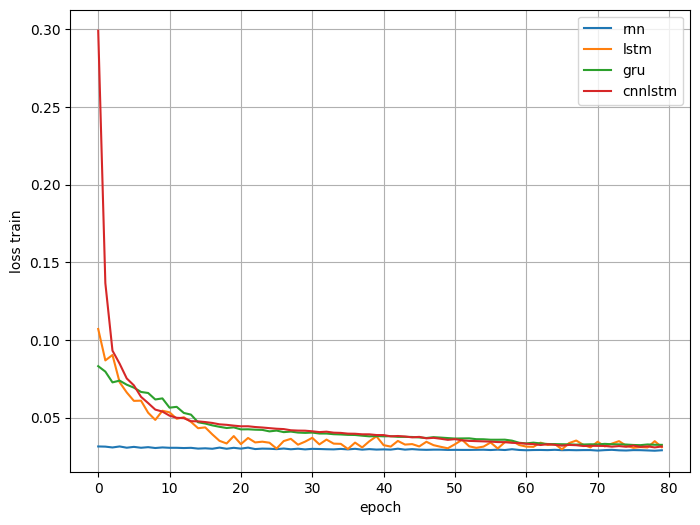

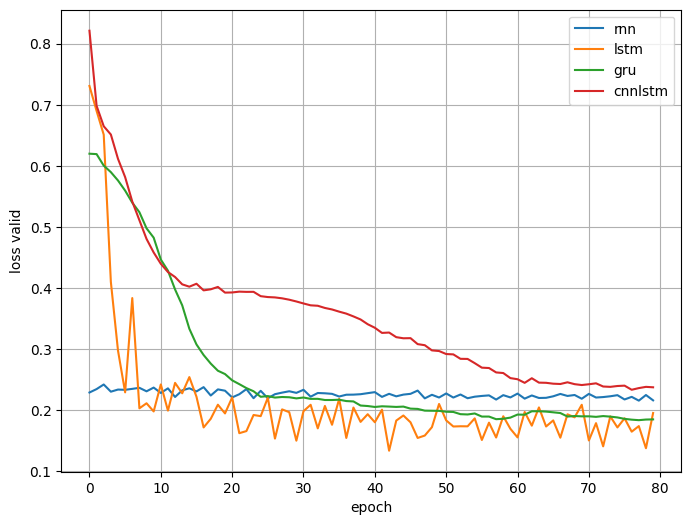

In [ ]:
def plot_lcs(x:str, y:str):
  plt.figure(figsize=(8, 6))
  #
  for model in ['rnn', 'lstm', 'gru', 'cnnlstm']:
    z = torch.load(f'/content/{model}-{x}-{y}.pt')
    #
    plt.plot(range(num_epochs), z, label=model)
    plt.xlabel('epoch')
    plt.ylabel(f'{x} {y}')
    plt.grid(True)
    plt.legend()

plot_lcs('loss', 'train')
plot_lcs('loss', 'valid')

##MAE Score for All Models

creat table and write MAE Values for all Models

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [ ]:
pred_dataset = x_test
mae_table = PrettyTable(["Model", "RNN", "LSTM", "GRU", "CNN-LSTM"])
MAX = y_max.item()

with torch.no_grad():
    mae = []

    for RNN in ['rnn', 'lstm', 'gru', 'cnnlstm']:

      x_test = x_test.to(device)
      model = torch.load(f'/content/{RNN}-model.pt')
      pred = model(x_test).to(device)
      mae.append(MAE(np.array(y_test) * MAX, np.array(pred.cpu()) * MAX))

    mae_table.add_row(['MAE', mae[0], mae[1], mae[2], mae[3]])


###Make Table

In [ ]:
print(mae_table)

+-------+-----------+----------+-----------+-----------+
| Model |    RNN    |   LSTM   |    GRU    |  CNN-LSTM |
+-------+-----------+----------+-----------+-----------+
|  MAE  | 145.87347 | 97.95716 | 136.31078 | 157.39905 |
+-------+-----------+----------+-----------+-----------+


#**Prediction🔎**

In [ ]:
pred_dataset = x_test
mdl = ['rnn', 'lstm', 'gru', 'cnnlstm']

with torch.no_grad():
    preds = []
    for RNN in ['rnn', 'lstm', 'gru', 'cnnlstm']:

      x_test = x_test.to(device)
      model = torch.load(f'/content/{RNN}-model.pt')
      pred = model(x_test).to(device)
      preds.append(pred.cpu())

##Load daily_cases.csv

In [ ]:
daily_cases = pd.read_csv('/content/daily_cases.csv',index_col=0)


##Plot

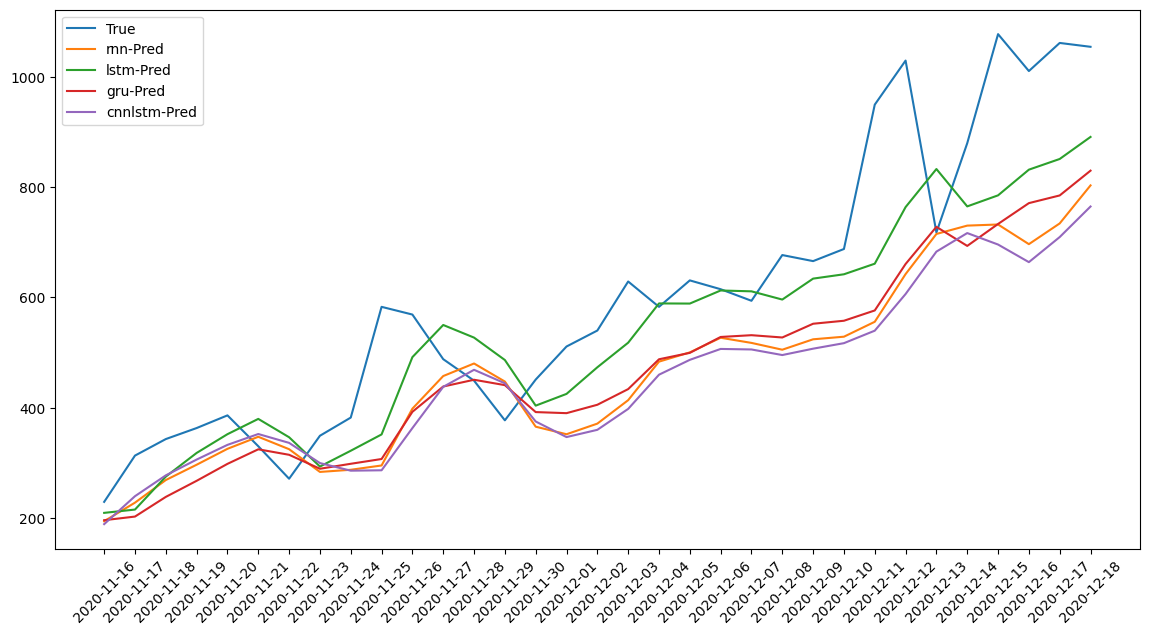

In [ ]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * y_max.item(), label='True')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[0]) * y_max.item(), label='rnn-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[1]) * y_max.item(), label='lstm-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[2]) * y_max.item(), label='gru-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[3]) * y_max.item(), label='cnnlstm-Pred')
plt.xticks(rotation=45)
plt.legend()